In [12]:
import datetime
import ee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
import os

ee.Initialize()

# Define init params - area, satellite, years

In [13]:
def init():
    
    '''
    Set the init params:
    1) Area
    2) Satellite 
    3) Years to analyze 
    
    '''
    
    ##### AREA #####
    
    # Whole state:
    area = (ee.FeatureCollection('ft:1fRY18cjsHzDgGiJiS2nnpUU3v9JPDc2HNaR7Xk8').filter(ee.Filter().eq('Name', 'California')))
    
    # County 
    area = (ee.FeatureCollection('ft:1FEPBzXYqUbdWXG2wTFOyb-ts9_GbeI5NFraMq2yk').filter(ee.Filter().eq('COUNTY num', 95)))
    
    # Central Valley
    area = ee.FeatureCollection('ft:1h46ENpEp8vO3pOe1EqeF1sZLEDhSVMxbu8pHAoU4', 'geometry')
    
    # CV watersheds
    # TODO 
    
    ###### SATELLITES ######
    
    trmm = ee.ImageCollection('TRMM/3B42')
    prism = ee.ImageCollection("OREGONSTATE/PRISM/AN81m")
    chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD')
    
    ##### TIME RANGE #####
    years = [x for x in range(2000, 2016)]
    
    return [[trmm,prism,chirps],area,years]
    

def retrieve(satellite):
    if satellite == ee.ImageCollection('TRMM/3B42'):
        var = "precipitation"
    if satellite == ee.ImageCollection("OREGONSTATE/PRISM/AN81m"):
        var = "ppt"
    if satellite == ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD'):
        var = "precipitation"
    return var

### Helpers 

In [14]:
def filter_date(product,year):
    startyear = ee.Date.fromYMD(year,1,1)
    endyear =ee.Date.fromYMD(year+1,12,31)
    prod = product.filterDate(startyear, endyear).sort('system:time_start', False).select(retrieve(product))
    return prod
    
def aggregate_precip(product,year):
    
    # Select appropriate resolution from product. Set lower if you exceed the google request
    if product == ee.ImageCollection('TRMM/3B42'):
        res = 12500
    elif product == ee.ImageCollection("OREGONSTATE/PRISM/AN81m"):
        res = 3200
    elif product == ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD'):
        res = 5500
    
    # Filter
    filtered = filter_date(product, year)

    # calculate the monthly mean
    def calcMean(imageCollection,year):
        mylist = ee.List([])
        months = range(1,13)
        for m in months:
                w = imageCollection.filter(ee.Filter.calendarRange(year, year, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).sum();
                mylist = mylist.add(w.set('year', year).set('month', m).set('date', ee.Date.fromYMD(year,m,1)).set('system:time_start',ee.Date.fromYMD(year,m,1)))
        return ee.ImageCollection.fromImages(mylist)

    # run the calcMonthlyMean function
    monthly = ee.ImageCollection(calcMean(filtered, year))

    # select the region of interest, res is the cellsize in meters
    monthly = monthly.getRegion(area,res,"epsg:4326").getInfo()

    return monthly 

def df_from_ee_object(imcol):
    df = pd.DataFrame(imcol, columns = imcol[0])
    df = df[1:]
    return(df)

def array_from_df(df, variable, month):
    df = df[df.id == str(month)] 
    
    # get data from df as arrays
    lons = np.array(df.longitude)
    lats = np.array(df.latitude)
    data = np.array(df[variable]) # Set var here 
                                              
    # get the unique coordinates
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)

    # get number of columns and rows from coordinates
    ncols = len(uniqueLons)    
    nrows = len(uniqueLats)

    # determine pixelsizes
    ys = uniqueLats[1] - uniqueLats[0] 
    xs = uniqueLons[1] - uniqueLons[0]

    # create an array with dimensions of image
    arr = np.zeros([nrows, ncols], np.float32)

    # fill the array with values
    counter =0
    for y in range(0,len(arr),1):
        for x in range(0,len(arr[0]),1):
            if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniqueLats)-1-y,x] = data[counter] # we start from lower left corner
    
    return arr

# Main

In [15]:
def main(years, product, timeseries = False):
    finals = []
    for year in years:
        finals.append(aggregate_precip(product,year))
    
    dfs = []
    for i in finals:
        dfs.append(df_from_ee_object(i))
    
    months = [int(x) for x in dfs[0].id.unique()]
    
    yearly = []
    for i in dfs:
        result = []
        for m in months:
            monthly = []
            a = array_from_df(i,retrieve(product),m)
            result.append(a)
        yearly.append(result)
        
    yearly_arrays = [np.array(x) for x in yearly]
    timeseries = [np.array(x) for x in yearly_arrays]
    all_data = [item for sublist in timeseries for item in sublist]
    final = np.dstack(all_data)
    final = np.ma.masked_where(final == 0, final)
    dist = final[np.logical_not(np.isnan(final))]
    
    return final

In [16]:
sats, area, years = init()

In [17]:
trmm = main(years, sats[0])
pris = main(years, sats[1])
chrps = main(years, sats[2])

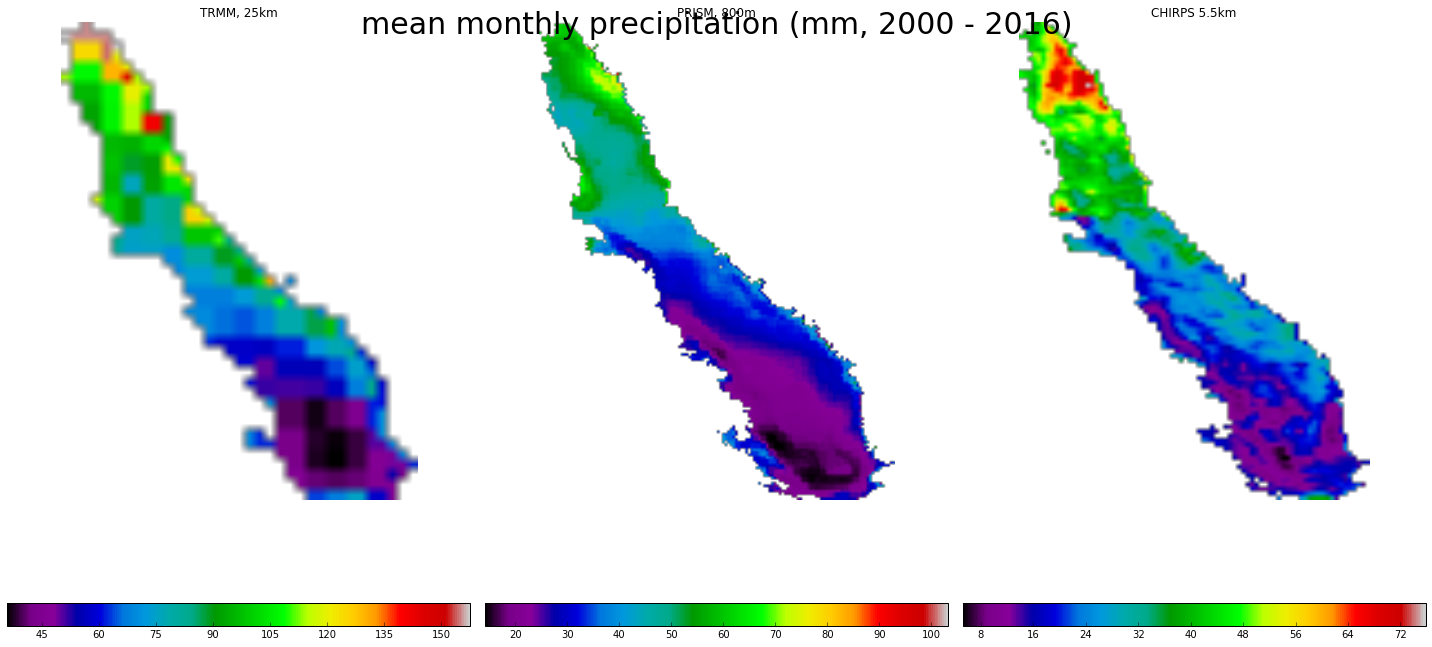

In [18]:
f = plt.figure(figsize=(20,10))

plt.suptitle("mean monthly precipitation (mm, 2000 - 2016)", size = 30)

plt.subplot(1,3,1)
plt.imshow(np.mean(trmm, axis = 2)*8,cmap = plt.get_cmap("spectral"))
plt.colorbar(orientation='horizontal')
plt.title("TRMM, 25km")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(np.mean(pris, axis = 2),cmap = plt.get_cmap("spectral"))
plt.title("PRISM, 800m")
plt.colorbar(orientation='horizontal')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(np.mean(chrps, axis = 2),cmap = plt.get_cmap("spectral"))
plt.title("CHIRPS 5.5km")
plt.colorbar(orientation='horizontal')
plt.axis('off')
plt.tight_layout()

plt.show()

In [19]:
plt.hist(dist, bins = 50)
plt.show()

NameError: name 'dist' is not defined

In [ ]:
def timeseries(years, product):
    finals = []
    for year in years:
        finals.append(aggregate_precip(product,year))
    
    dfs = []
    for i in finals:
        dfs.append(df_from_ee_object(i))
    
    months = [int(x) for x in dfs[0].id.unique()]
    
    yearly = []
    for i in dfs:
        result = []
        for m in months:
            monthly = []
            a = array_from_df(i,retrieve(product),m)
            result.append(a)
        yearly.append(result)
        
    yearly_arrays = [np.array(x) for x in yearly]
    timeseries = [np.array(x) for x in yearly_arrays]
    all_data = [item for sublist in timeseries for item in sublist]
    
    return all_data

In [ ]:
from dateutil.relativedelta import relativedelta

trmm = timeseries(years, sats[0])
pris = timeseries(years, sats[1])
chrps = timeseries(years, sats[2])

In [ ]:
trmm_sums = [np.sum(x)*24 for x in trmm]
prism_sums = [np.sum(x) for x in pris]
chrps_sums = [np.sum(x) for x in chrps]

dates = [datetime.date(2000, 1, 1) + relativedelta(months=x) for x in range(0, 192)]

plt.figure(figsize=(10,5))
plt.title("Monthly Precipitation sums(mm) timeseries")
plt.plot(dates,trmm_sums, label = "trmm")
plt.plot(dates,prism_sums, label = "prism")
plt.plot(dates,chrps_sums, label = "chirps")
plt.ylabel("precipitation (mm)")
plt.xlabel("Date")
plt.legend()
plt.show()

# Make a movie of precip over time

In [51]:
# create a ScalarMappable, initialize a data structure, fake the array of the scalar mappable, set max to 99th percentile of data
sm = plt.cm.ScalarMappable(cmap="spectral", norm=plt.Normalize(vmin=0, vmax=1200))#vmax=np.percentile(final, 99)))
sm._A = []
plt.clf()

s = np.shape(final)
nFrames = 12*16 # 12 months * 16 years
A = np.zeros((final.shape[0], final.shape[1], nFrames))

# Make the dates to be annotated
dates = []

mons = range(1,13)
yrs = range(2000,2016)

for y in yrs:
    for m in mons:
        dates.append(datetime.date(y,m,1))  #year, month, day


# Set up plotting
fig = plt.figure()
ax = plt.axis('off')
cbar = plt.colorbar(sm)
t = plt.title("monthly PRISM precipitation sums (mm)")

# Animation function
def animate(i): 
    result = plt.imshow(final[:,:,i],cmap = plt.get_cmap("spectral"))
    text = plt.text(300,20,str(dates[i])[:-3], ha='center', va='center', backgroundcolor='white')
    
    return result

anim = animation.FuncAnimation(fig, animate, frames=nFrames)

In [52]:
from IPython.display import HTML
HTML(anim.to_html5_video())

![title](prism.gif)

Now you have the monthly sums in a 3d array

# Visualize the monthly sums

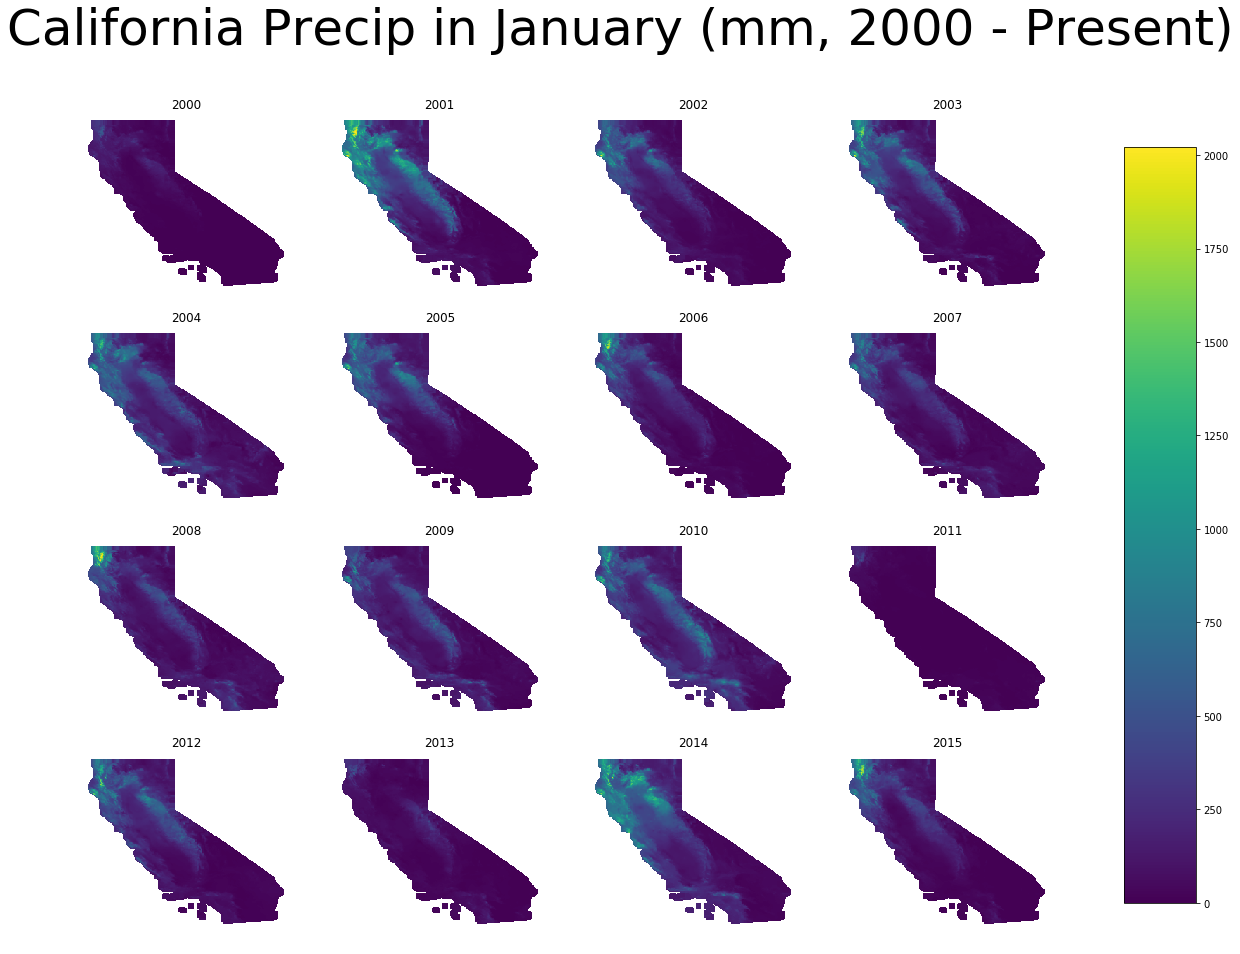

In [55]:
fig, axs = plt.subplots(4,4, figsize=(20,15))
axs = axs.ravel()

plt.suptitle('California Precip in January (mm, 2000 - Present)', size = 50)

for i in range(len(dfs)):
    
    a = axs[i].scatter(dfs[i]['longitude'],dfs[i]['latitude'],marker = "s",c = dfs[i]['ppt'],s= 20, lw = 0)
    axs[i].set_title(2000+i)
    axs[i].axis('off')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(a, cax=cbar_ax)

plt.show()

# Write to csv

In [ ]:
dfs_by_year = dict(zip(years,dfs))
for k,v in dfs_by_year.items():
    path = os.path.join(os.getcwd(), "trmm_csvs")
    v.to_csv(os.path.join(path,str(k)+"_.csv"))